In [1]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
def load_data(filename):
    epoch = datetime(1970, 1, 1) #Use 01/01/1970 as the reference point for time
    f = open(filename, 'r')  #Open the specified text file
    x = [] #List of time values
    y = [] #List of level values
    for l in f:
        #Go line by line
        l = l.replace('\n', '') #Errase the new line symbol
        ls = l.split(';') #Split lines
        y.append(float(ls[1])) #Convert text to float
        
        #Convert time data to seconds
        x.append(((datetime.strptime(ls[0], '%Y-%m-%d %H:%M:%S'))-epoch).total_seconds()) 
        
    f.close() #Close text file    
    
    #Return numpy arrays
    return np.array(x), np.array(y)

In [3]:
def smooth(x, window_size):
    # Smoothing function. Given an array (x) and the width of the window, returns the smoothed sequence of values
    w = np.hamming(window_size) # Use Hamming window for convolution
    w = w/np.trapz(w) # Normalize 
    return np.convolve(w,x,mode='same') # Returned the smoothed signal

In [4]:
def refine(x, y):
    # Makes sure that the y values of a sequence are evenly spaced throught the domain x
    rx = np.linspace(np.min(x), np.max(x), len(x)*2) # Generate a sequence with evenly spaced values
    ry = np.interp(rx, x, y) # Interpolate the y values for each of the generated elements of the domain    
    return rx, ry

In [5]:
def pad(x, y, size):
    # Add extra elements to the signal at the beginning and end equal to the first and last elements of the sequence 
    py = np.lib.pad(y, (size, size), 'edge') # Add extra values to the image
    start_dx = x[1]-x[0]
    end_dx = x[-1] - x[-2]
    px = np.lib.pad(x, (size, size), 'linear_ramp', end_values=(x[0]-start_dx*size, start_dx*size+x[-1])) # Extend domain
    return px, py

In [6]:
def dead_band(y, y_min, y_max, val=0):
    # Simple dead-band. Finds elements outside a window and sets them to a given value
    cy = np.copy(y)
    index = np.where(np.logical_and(cy>=y_min, cy<=y_max)) 
    cy[index] = val
    return cy

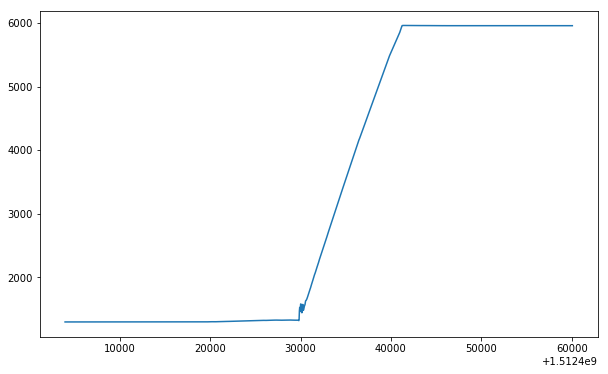

In [7]:
x, y = load_data('tank.txt') # Load tank data
s_window = 20 # Use 20 samples for the window size of the filter
pad_window = s_window * 20 # Size of elements to add to the sequence

x,y = refine(x, y) # Make sure (x,y) elements are evenly spaced throughout the domain
x, y = pad(x, y, pad_window) # Pad sequence

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.show()

# Smooth signal
sy = smooth(y, s_window)

# Compute derivative 
dy = np.gradient(y)/np.gradient(x)
dsy = np.gradient(sy)/np.gradient(x)

# Remove padded elements
dsy = dsy[pad_window:-pad_window]

sdsy = np.copy(dsy)

# Change units of derivate (optional)
sdsy = sdsy * 1.68 / 10.0 * 3600.0

# Remove padded elements
x = x[pad_window:-pad_window]
y = y[pad_window:-pad_window]
sy = sy[pad_window:-pad_window]
dy = dy[pad_window:-pad_window]

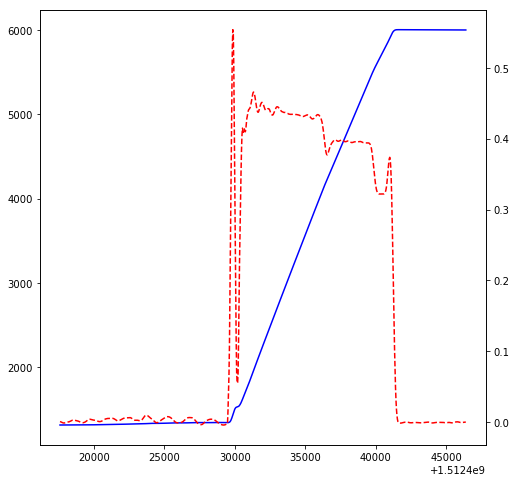

In [8]:
# Plot tank level + derivative
f, ax1 = plt.subplots()
ax1.plot(x, sy, 'b-')
ax2 = ax1.twinx()  # make a second axes that shares the same x-axis
ax2.plot(x, dsy, 'r--')
f.set_figheight(8)
f.set_figwidth(8)
plt.show()

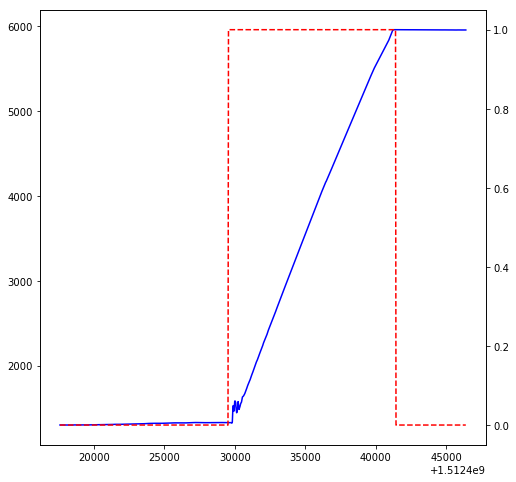

In [9]:
dead_sdsy = dead_band(sdsy, -20, 20) # Apply dead-band
sign_dy= np.sign(dead_sdsy) # Only retain sign information

# Plot the tank level + sign of derivative
f, ax1 = plt.subplots()
ax1.plot(x, y, 'b-')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, sign_dy, 'r--')
f.set_figheight(8)
f.set_figwidth(8)
plt.show()
